In [1]:
%matplotlib inline

This Notebook will take and extract all of the distances of all of the routes between each level and draw distritions of them.

In [2]:
import ipath
import os,sys
import shadow_network
from shadow_network_db_api import ShdNetworkDB
import input
from util import AccumVal

Specify here where the model files you would like to work on are and what the input file name is

In [3]:
models = {
        "Mozambique":{'modeldir':'C:\\Users\\Shawn\\Downloads\\Moz_current_2016_10DoseBCG_5',
                      'modelkvp':"Moz_current_2016_10DoseBCG.kvp"},
        "Benin":{'modeldir':'D:\\Programs\\HERMES2\\oldmodels\\benin_2012',
                 'modelkvp':'benin_input.kvp'},
        "Bihar":{'modeldir':'D:\\Programs\\HERMES2\\oldmodels\\Bihar',
                 'modelkvp':'Bihar.kvp'}
    }
    
os.environ["HERMES_DATA_PATH"] = "D:\\Programs\\HERMES2\\HERMES2\\master_data\\unified"

Create a Shadow_network model from the inputs

In [28]:
def fillDistanceDict(modeldir,modelkvp):
    os.chdir(modeldir)
    userInput = input.UserInput(modelkvp, False)
    shdTypes = shadow_network.loadShdTypes(userInput, input.UnifiedInput())
    shdNtwk = shadow_network.loadShdNetwork(userInput, shdTypes, "model")
    
    distanceDict = {}
    for routeId,route in shdNtwk.routes.items():
        stops = route.stops
        for s in range(0,len(stops)):
            stop0 = stops[s]
            if s == len(stops)-1:
                stop1 = stops[0]
            else:
                stop1 = stops[s+1]

            stopTup = (stop0.store.CATEGORY,stop1.store.CATEGORY)
            revTup = (stop1.store.CATEGORY,stop0.store.CATEGORY)
            stopDist = stop0.DistanceKM

            if stopDist:
                if stopTup not in distanceDict.keys() and revTup not in distanceDict.keys():
                    distanceDict[stopTup] = {'func':None,'value':AccumVal(stopDist)}
                elif revTup in distanceDict.keys():
                    distanceDict[revTup]['value'] += stopDist
                else:
                    distanceDict[stopTup]['value'] += stopDist
            
    return (shdNtwk,distanceDict)

In [29]:
print os.getenv("HERMES_DATA_PATH")
modelDict = {}
for model,info in models.items():
    print info
    ntwk,distanceDict = fillDistanceDict(info['modeldir'],info['modelkvp'])
    modelDict[model] = {'shdntwk':ntwk,'distanceDict':distanceDict}
#distanceDict = fillDistanceDict(modeldir,modelkvp)

D:\Programs\HERMES2\HERMES2\master_data\unified
{'modelkvp': 'Moz_current_2016_10DoseBCG.kvp', 'modeldir': 'C:\\Users\\Shawn\\Downloads\\Moz_current_2016_10DoseBCG_5'}
{'modelkvp': 'Bihar.kvp', 'modeldir': 'D:\\Programs\\HERMES2\\oldmodels\\Bihar'}
{'modelkvp': 'benin_input.kvp', 'modeldir': 'D:\\Programs\\HERMES2\\oldmodels\\benin_2012'}


In [18]:
print modelDict['Bihar']['distanceDict']

{(u'PHC', u'Division'): AccumVal([12.0, 12.0, 12.0, 12.0, 25.0, 25.0, 25.0, 25.0, 10.0, 10.0, 35.0, 35.0, 32.0, 32.0, 60.0, 60.0, 65.0, 65.0, 35.0, 35.0, 2.0, 2.0, 35.0, 35.0, 55.0, 55.0, 22.0, 22.0, 24.0, 24.0, 18.0, 18.0, 38.0, 38.0, 20.0, 20.0, 25.0, 25.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 15.0, 15.0, 12.0, 12.0, 30.0, 30.0, 60.0, 60.0, 45.0, 45.0]), (u'PHC', u'District'): AccumVal([10.0, 10.0, 8.0, 8.0, 19.6, 19.6, 12.0, 12.0, 35.0, 35.0, 48.0, 48.0, 37.0, 37.0, 40.0, 40.0, 30.0, 30.0, 42.0, 42.0, 58.0, 58.0, 45.0, 45.0, 65.0, 65.0, 31.0, 31.0, 18.0, 18.0, 22.0, 22.0, 70.0, 70.0, 30.0, 30.0, 40.0, 40.0, 22.0, 22.0, 15.0, 15.0, 6.0, 6.0, 25.0, 25.0, 32.0, 32.0, 0.5, 0.5, 46.0, 46.0, 10.0, 10.0, 65.0, 65.0, 25.0, 25.0, 187.0, 187.0, 32.0, 32.0, 4.0, 4.0, 38.0, 38.0, 10.0, 10.0, 30.0, 30.0, 25.0, 25.0, 50.0, 50.0, 60.0, 60.0, 24.0, 24.0, 32.0, 32.0, 28.0, 28.0, 1.0, 1.0, 25.0, 25.0, 15.0, 15.0, 40.0, 40.0, 20.0, 20.0, 42.0, 42.0, 35.0, 35.0, 23.0, 23.0, 20.0, 20.0, 18.0, 18.0, 74.0,

In [42]:
for levelTup,distAccum in distanceDict.items():
    print "Between Levels: {0} and {1}".format(levelTup[0],levelTup[1])
    print "    mean: {0}".format(distAccum.mean())
    print "    min:  {0}".format(distAccum.min())
    print "    max:  {0}".format(distAccum.max())
    print "    histogram: {0}".format(distAccum.v)

Between Levels: Provincial and Centro de Saude
    mean: 161.642857143
    min:  7.0
    max:  450.0
    histogram: [7.0, 10.0, 18.0, 60.0, 68.0, 92.0, 112.0, 121.0, 123.0, 183.0, 245.0, 350.0, 424.0, 450.0]
Between Levels: Centro de Saude and Centro de Saude
    mean: 41.4174688057
    min:  0.1
    max:  367.0
    histogram: [0.1, 0.1, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 17.0, 1

In [30]:
from scipy.stats import norm,rayleigh,exponweib
#from numpy.random import normal,rayleigh,weibull
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

(1, 1.0139983604956315, 0, 162.53629811359085)


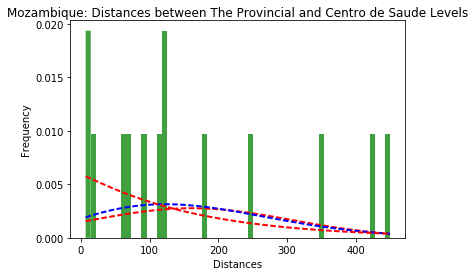

Normal Distribution: mu=161.642857143 sigma=144.411914399
Rayleigh Distribution: loc=-70.5090135504 scale=193.325214437
Weibull Distribution: params=(1, 1.0139983604956315, 0, 162.53629811359085)
(1, 1.232120958177197, 0, 44.597720737778289)


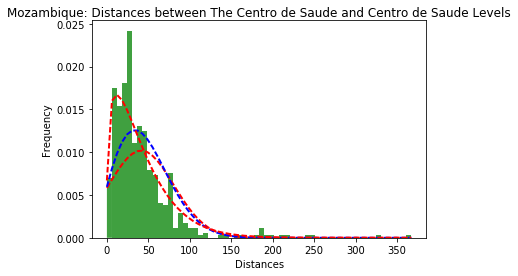

Normal Distribution: mu=41.4174688057 sigma=39.1466425577
Rayleigh Distribution: loc=-14.3762495416 scale=48.1943784851
Weibull Distribution: params=(1, 1.232120958177197, 0, 44.597720737778289)
(1, 1.6101541344627783, 0, 92.985218028956936)


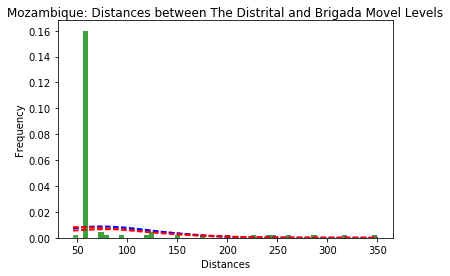

Normal Distribution: mu=82.1157894737 sigma=60.0224279412
Rayleigh Distribution: loc=4.37467020594 scale=69.4491544828
Weibull Distribution: params=(1, 1.6101541344627783, 0, 92.985218028956936)
(1, 1.4120721491648993, 0, 57.838240147271065)


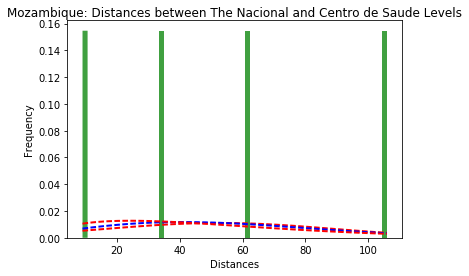

Normal Distribution: mu=52.75 sigma=36.0095473451
Rayleigh Distribution: loc=-10.7350405445 scale=51.6092624974
Weibull Distribution: params=(1, 1.4120721491648993, 0, 57.838240147271065)
(1, 1.1761663759300938, 0, 51.613175166302526)


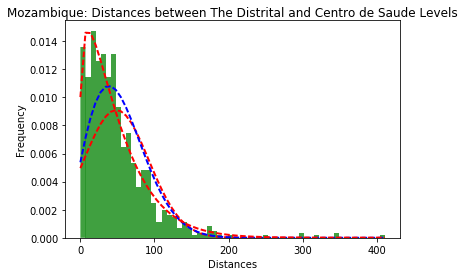

Normal Distribution: mu=48.7851809955 sigma=43.8198442602
Rayleigh Distribution: loc=-17.2818876213 scale=56.0581809723
Weibull Distribution: params=(1, 1.1761663759300938, 0, 51.613175166302526)
(1, 1.081143828501693, 0, 960.05835763348091)


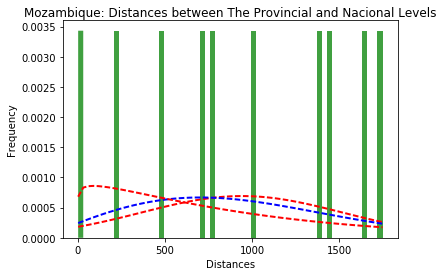

Normal Distribution: mu=942.6 sigma=576.561913414
Rayleigh Distribution: loc=-204.043978734 scale=907.528518295
Weibull Distribution: params=(1, 1.081143828501693, 0, 960.05835763348091)
(1, 1.9516818969716461, 0, 52.686857357080669)


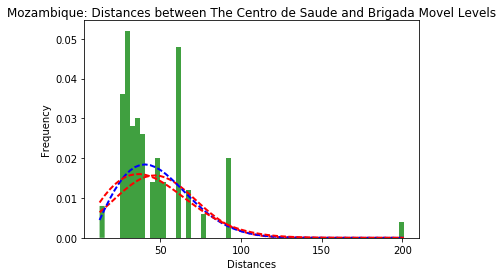

Normal Distribution: mu=46.5597484277 sigma=25.4462910013
Rayleigh Distribution: loc=7.60654594568 scale=32.9003373152
Weibull Distribution: params=(1, 1.9516818969716461, 0, 52.686857357080669)
(1, 1.0507764224868839, 0, 229.66654161522303)


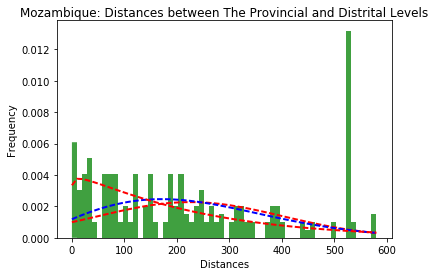

Normal Distribution: mu=225.970588235 sigma=175.435003096
Rayleigh Distribution: loc=-74.7594093418 scale=246.186911449
Weibull Distribution: params=(1, 1.0507764224868839, 0, 229.66654161522303)
(1, 18.186963489280412, 0, 258.24635890871423)


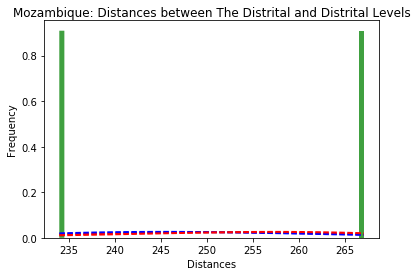

Normal Distribution: mu=250.5 sigma=16.5
Rayleigh Distribution: loc=221.921173701 scale=23.3344948582
Weibull Distribution: params=(1, 18.186963489280412, 0, 258.24635890871423)
(1, 1.92571373908623, 0, 33.410283885195426)


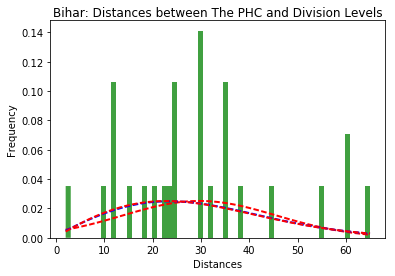

Normal Distribution: mu=29.7037037037 sigma=15.8880687002
Rayleigh Distribution: loc=-0.895598807499 scale=24.3797755156
Weibull Distribution: params=(1, 1.92571373908623, 0, 33.410283885195426)
(1, 1.466207878883333, 0, 37.169682619505849)


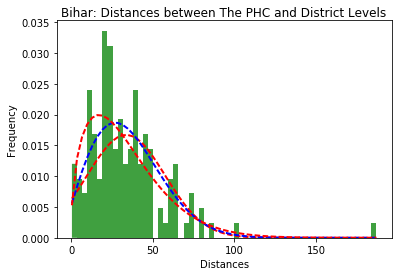

Normal Distribution: mu=33.7059701493 sigma=23.8809665083
Rayleigh Distribution: loc=-5.47694223786 scale=32.4468545328
Weibull Distribution: params=(1, 1.466207878883333, 0, 37.169682619505849)
(1, 2.2239302545141006, 0, 209.97669360501573)


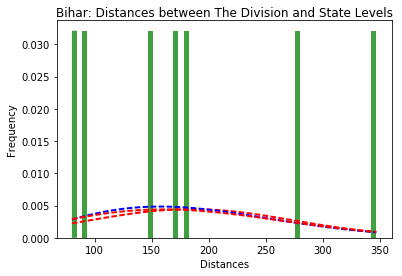

Normal Distribution: mu=185.0 sigma=89.7759115003
Rayleigh Distribution: loc=32.3843045326 scale=125.202385718
Weibull Distribution: params=(1, 2.2239302545141006, 0, 209.97669360501573)
(1, 6.9302115338621499, 0, 167.27644028284507)


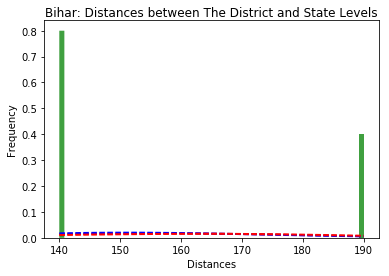

Normal Distribution: mu=156.666666667 sigma=23.5702260396
Rayleigh Distribution: loc=120.376500453 scale=30.5984397595
Weibull Distribution: params=(1, 6.9302115338621499, 0, 167.27644028284507)
(1, 2.7081816936114382, 0, 96.445356347745957)


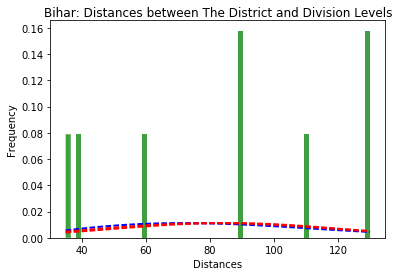

Normal Distribution: mu=85.45 sigma=35.3577077877
Rayleigh Distribution: loc=17.7022985319 scale=54.0366442233
Weibull Distribution: params=(1, 2.7081816936114382, 0, 96.445356347745957)
(1, 1.1518766614321272, 0, 70.655751391491947)


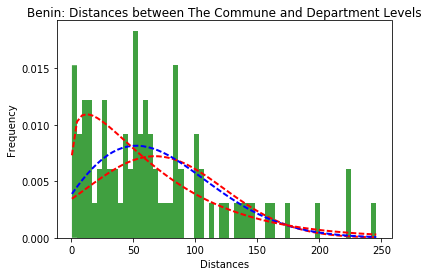

Normal Distribution: mu=67.4133025439 sigma=55.2441956129
Rayleigh Distribution: loc=-22.1723946949 scale=74.4228239019
Weibull Distribution: params=(1, 1.1518766614321272, 0, 70.655751391491947)
(1, 1.6574637376373538, 0, 218.44552568089813)


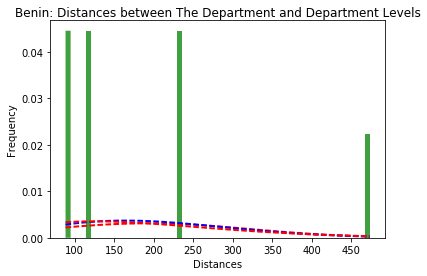

Normal Distribution: mu=193.227775029 sigma=128.206441726
Rayleigh Distribution: loc=0.159014521276 scale=163.878686823
Weibull Distribution: params=(1, 1.6574637376373538, 0, 218.44552568089813)
(1, 0.97510344001819038, 0, 18.732583526723644)


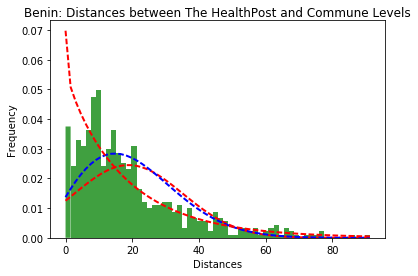

Normal Distribution: mu=18.8906781747 sigma=16.2708648733
Rayleigh Distribution: loc=-6.5598106026 scale=21.3596564604
Weibull Distribution: params=(1, 0.97510344001819038, 0, 18.732583526723644)
(1, 0.49137560520439838, 0, 64.703697467800112)


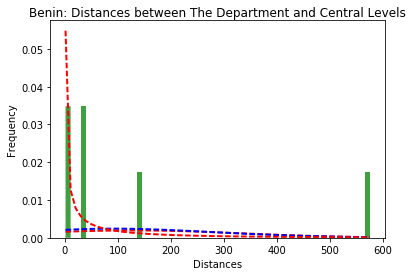

Normal Distribution: mu=128.850534083 sigma=204.744415187
Rayleigh Distribution: loc=-160.261713578 scale=250.505632213
Weibull Distribution: params=(1, 0.49137560520439838, 0, 64.703697467800112)


In [32]:
for model,modelD in modelDict.items():
    distanceDict = modelD['distanceDict']
    for levelTup,distA in distanceDict.items():
        # Normal Distribution Fit
        distAccum = distA['value']
        (mu,sigma) = norm.fit(distAccum.v)
        (loc,scale) = rayleigh.fit(distAccum.v)
        modelDict[model]['distanceDict'][levelTup]['funcs'] = {'normal':(mu,sigma),'rayleigh':(loc,scale)}
        eFit = exponweib.fit(distAccum.v,floc=0,f0=1)
        print eFit
        n,bins,patches = plt.hist(distAccum.v,60,normed=1,facecolor='green',alpha=0.75)
        y = mlab.normpdf(bins,mu,sigma)
        y2 = rayleigh.pdf(bins,loc=loc,scale=scale)
        y3 = exponweib.pdf(bins,*eFit)

        l = plt.plot(bins,y,'r--',linewidth=2)
        l2 = plt.plot(bins,y2,'b--',linewidth=2)
        l3 = plt.plot(bins,y3,'r--',linewidth=2)
        plt.xlabel('Distances')
        plt.ylabel('Frequency')
        plt.title('{2}: Distances between The {0} and {1} Levels'.format(levelTup[0],levelTup[1],model))
        #plt.grid(true)
        plt.show()
        print "Normal Distribution: mu={0} sigma={1}".format(mu,sigma)
        print "Rayleigh Distribution: loc={0} scale={1}".format(loc,scale)
        print "Weibull Distribution: params={0}".format(eFit)